<h1>C4 Solution</h1>

<h3>Get the data and copy it to S3</h3>

In [2]:
%%capture
!pip install smdebug torch torchvision tqdm

In [3]:
# session and role
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
import os
from time import time

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = "us-east-1"

data_bucket = bucket
# Upload data to S3 bucket.
datapath = 'images'

print(sagemaker_session, bucket, role, region, '\n')

s3_data_dir = "s3://{}/{}/".format(data_bucket, datapath)
s3_output_dir = "s3://{}/{}/".format(bucket, "output")
s3_model_dir = "s3://{}/{}/".format(bucket, "model")

print(f's3_data_dir = {s3_data_dir}')

<sagemaker.session.Session object at 0x7fcba82bead0> sagemaker-us-east-1-697405440952 arn:aws:iam::697405440952:role/service-role/AmazonSageMaker-ExecutionRole-20211126T034962 us-east-1 

s3_data_dir = s3://sagemaker-us-east-1-697405440952/images/


In [4]:
os.environ["DEFAULT_S3_BUCKET"] = bucket
os.environ['SM_CHANNEL_TRAIN']= s3_data_dir
os.environ['SM_OUTPUT_DATA_DIR']= s3_output_dir
os.environ['SM_MODEL_DIR']= s3_model_dir

print(os.environ['SM_CHANNEL_TRAIN'])

s3://sagemaker-us-east-1-697405440952/images/


In [ ]:

# Upload data to S3 bucket.
inputs = sagemaker_session.upload_data(path=datapath, bucket=data_bucket, key_prefix=datapath)
print(inputs)

<h3>Set up parameters, estimator, and tuner</h3>

In [5]:
# batch_size 128, 256 tuner failed - not enough cuda memory - Cloud watch !!!
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.0008, 0.0012),
    "batch_size": CategoricalParameter([32, 64, 128]),
}

role = sagemaker.get_execution_role()

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]
# objective_metric_name = "Test Loss"
# objective_type = "Minimize"
# metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [6]:
# ml.m5.xlarge 
estimator = PyTorch(
    entry_point="fm_hpo.py",
    base_job_name='pytorch_fmnist',
    role=role,
#     framework_version="1.4.0",
    framework_version="1.8.0",
    instance_count=1,
    instance_type="ml.g4dn.12xlarge",
    py_version='py36'
#     py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type
)

<h3>Fit the tuner</h3>

In [7]:
begin = time()
tuner.fit({"train": s3_data_dir})
tunning_time = time() - begin
mins = tunning_time // 60
seds = tunning_time % 60
print(f'Tunning time: {mins: .0f}m {seds: .0f}s')


....................................................................................................................................................!
Tunning time:  12m  28s


In [8]:
# TODO: Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_hypers = best_estimator.hyperparameters()

# To know exact data from best_estimator.hyperparameters()
print(best_hypers)


2022-02-07 08:56:46 Starting - Preparing the instances for training
2022-02-07 08:56:46 Downloading - Downloading input data
2022-02-07 08:56:46 Training - Training image download completed. Training in progress.
2022-02-07 08:56:46 Uploading - Uploading generated training model
2022-02-07 08:56:46 Completed - Training job completed
{'_tuning_objective_metric': '"average test loss"', 'batch_size': '"64"', 'learning_rate': '0.000988624968369079', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"pytorch_fmnist-2022-02-07-08-44-33-486"', 'sagemaker_program': '"fm_hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-697405440952/pytorch_fmnist-2022-02-07-08-44-33-486/source/sourcedir.tar.gz"'}


In [9]:
with open ('best_hypers.txt', 'w') as f:
    f.write(str(best_hypers))


<h3>Describe the tuning results</h3>


<h3>Prepare to perform Training on Best Estimator</h3>

In [10]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"64"',
 'learning_rate': '0.000988624968369079',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_fmnist-2022-02-07-08-44-33-486"',
 'sagemaker_program': '"fm_hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-697405440952/pytorch_fmnist-2022-02-07-08-44-33-486/source/sourcedir.tar.gz"'}

In [11]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "lr": best_estimator.hyperparameters()['learning_rate']}
hyperparameters

{'batch_size': 64, 'lr': '0.000988624968369079'}

In [12]:
# rules = [
#     Rule.sagemaker(rule_configs.vanishing_gradient()),
#     Rule.sagemaker(rule_configs.overfit()),
#     Rule.sagemaker(rule_configs.overtraining()),
#     Rule.sagemaker(rule_configs.poor_weight_initialization()),
#     ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
# ]
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
    ProfilerRule,
    ProfilerConfig, 
    FrameworkProfile
)

rules = [
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(base_config=rule_configs.class_imbalance(),
                   rule_parameters={"labels_regex": "CrossEntropyLoss_input_1"})
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

<h2>Creating an Estimator</h2>

In [13]:
#adjust this cell to accomplish multi-instance training
#     instance_type='ml.m5.xlarge',
estimator = PyTorch(
    entry_point='fm_model.py',
    base_job_name='pytorch-fmnist',
    role=role,
    instance_count=1,
    instance_type='ml.g4dn.12xlarge',
    framework_version='1.8.0',
    py_version='py36',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=debugger_hook_config,
    profiler_config=profiler_config,
)

In [14]:
begin = time()

estimator.fit({"train": s3_data_dir}, wait=True)

training_time = time() - begin
mins = training_time // 60
seds = training_time % 60
print(f'Tunning time: {mins: .0f}m {seds: .0f}s')

### Wait until training job finish -Sagemaker training jobs view

2022-02-07 08:58:39 Starting - Starting the training job...
2022-02-07 08:58:45 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ClassImbalance: InProgress
ProfilerReport: InProgress
......
2022-02-07 09:00:36 Starting - Preparing the instances for training......
2022-02-07 09:01:36 Downloading - Downloading input data.............................................
2022-02-07 09:09:10 Training - Downloading the training image...
2022-02-07 09:09:38 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-02-07 09:09:26,556 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-02-07 09:09:26,596 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-02-07 09:09:32,827 sagemaker_py

In [15]:
# We can check the status of our training job, 
# by executing describe_training_job
training_job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
print(f"Training job name: {training_job_name}")
print(f"Region: {region}")

Training job name: pytorch-fmnist-2022-02-07-08-58-38-441
Region: us-east-1


In [16]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

# Fetch tensor names and print their lengths
trial.tensor_names()

tensor_name = "CrossEntropyLoss_output_0"
print(len(trial.tensor(tensor_name).steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor(tensor_name).steps(mode=ModeKeys.EVAL)))

[2022-02-07 09:19:02.381 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-02-07 09:19:02.391 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-697405440952/pytorch-fmnist-2022-02-07-08-58-38-441/debug-output
[2022-02-07 09:19:06.446 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-02-07 09:19:07.470 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO trial.py:210] Loaded all steps
150
392


In [17]:
# Set up functions to plot the output tensors

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [18]:
get_data(trial, tensor_name, mode=ModeKeys.TRAIN)

([0,
  100,
  200,
  300,
  400,
  500,
  600,
  700,
  800,
  900,
  1000,
  1100,
  1200,
  1300,
  1400,
  1500,
  1600,
  1700,
  1800,
  1900,
  2000,
  2100,
  2200,
  2300,
  2400,
  2500,
  2600,
  2700,
  2800,
  2900,
  3000,
  3100,
  3200,
  3300,
  3400,
  3500,
  3600,
  3700,
  3800,
  3900,
  4000,
  4100,
  4200,
  4300,
  4400,
  4500,
  4600,
  4700,
  4800,
  4900,
  5000,
  5100,
  5200,
  5300,
  5400,
  5500,
  5600,
  5700,
  5800,
  5900,
  6000,
  6100,
  6200,
  6300,
  6400,
  6500,
  6600,
  6700,
  6800,
  6900,
  7000,
  7100,
  7200,
  7300,
  7400,
  7500,
  7600,
  7700,
  7800,
  7900,
  8000,
  8100,
  8200,
  8300,
  8400,
  8500,
  8600,
  8700,
  8800,
  8900,
  9000,
  9100,
  9200,
  9300,
  9400,
  9500,
  9600,
  9700,
  9800,
  9900,
  10000,
  10100,
  10200,
  10300,
  10400,
  10500,
  10600,
  10700,
  10800,
  10900,
  11000,
  11100,
  11200,
  11300,
  11400,
  11500,
  11600,
  11700,
  11800,
  11900,
  12000,
  12100,
  12200,
  123

In [19]:
get_data(trial, tensor_name, mode=ModeKeys.EVAL)

([0,
  10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190,
  200,
  210,
  220,
  230,
  240,
  250,
  260,
  270,
  280,
  290,
  300,
  310,
  320,
  330,
  340,
  350,
  360,
  370,
  380,
  390,
  400,
  410,
  420,
  430,
  440,
  450,
  460,
  470,
  480,
  490,
  500,
  510,
  520,
  530,
  540,
  550,
  560,
  570,
  580,
  590,
  600,
  610,
  620,
  630,
  640,
  650,
  660,
  670,
  680,
  690,
  700,
  710,
  720,
  730,
  740,
  750,
  760,
  770,
  780,
  790,
  800,
  810,
  820,
  830,
  840,
  850,
  860,
  870,
  880,
  890,
  900,
  910,
  920,
  930,
  940,
  950,
  960,
  970,
  980,
  990,
  1000,
  1010,
  1020,
  1030,
  1040,
  1050,
  1060,
  1070,
  1080,
  1090,
  1100,
  1110,
  1120,
  1130,
  1140,
  1150,
  1160,
  1170,
  1180,
  1190,
  1200,
  1210,
  1220,
  1230,
  1240,
  1250,
  1260,
  1270,
  1280,
  1290,
  1300,
  1310,
  1320,
  1330,
  1340,
  1350,
  1360,
  1370,
  1380,

In [20]:
# Create a function to plot 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, 
                                       mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, 
                                     mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(16, 10))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("TRAIN Steps")
    par.set_xlabel("EVAL Steps")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


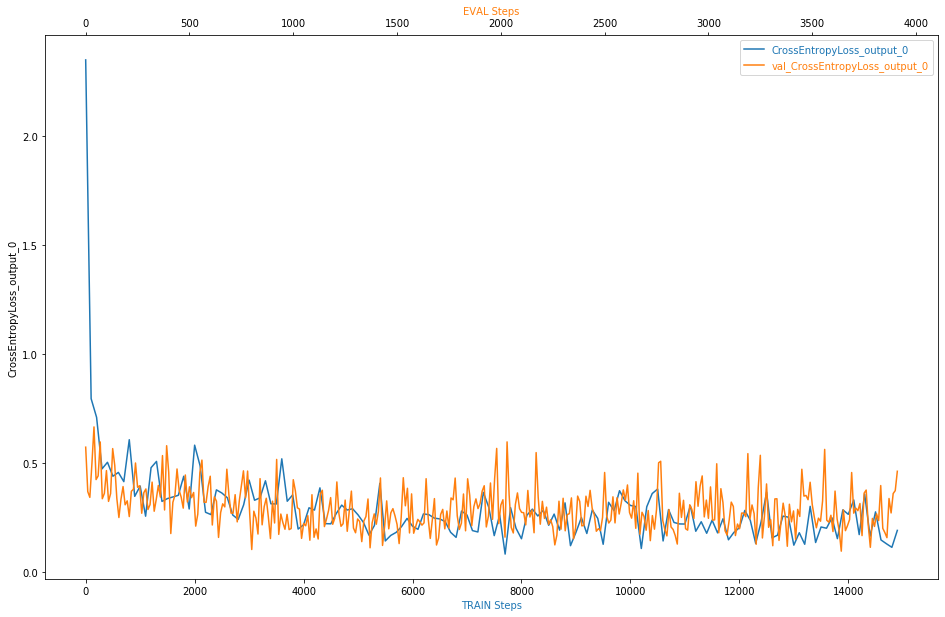

In [21]:
#Plot a debugging output.
plot_tensor(trial, tensor_name)

In [22]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-697405440952/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-697405440952/pytorch-fmnist-2022-02-07-08-58-38-441/profiler-output


Profiler data from system is available


In [23]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2022-02-07 09:23:17.958 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO metrics_reader_base.py:134] Getting 17 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1'}


In [24]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-697405440952/pytorch-fmnist-2022-02-07-08-58-38-441/rule-output


In [25]:
# ! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-697405440952/pytorch-fmnist-2022-02-07-08-58-38-441/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-697405440952/pytorch-fmnist-2022-02-07-08-58-38-441/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-697405440952/pytorch-fmnist-2022-02-07-08-58-38-441/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-697405440952/pytorch-fmnist-2022-02-07-08-58-38-441/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-east-1-697405440952/pytorc

In [26]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]
print(profiler_report_name)

ProfilerReport


In [27]:
! tar czf ProfilerReport.tgz ProfilerReport/

# Deployment

In [28]:
### Wait until training job finish -Sagemaker training jobs view
# model_location = 's3://sagemaker-us-east-1-141102501120/dog-pytorch-2021-12-21-03-54-25-024/output/model.tar.gz'
# model_location=estimator.model_data
# 
# training_job_name='pytorch-fmnist-2022-02-03-16-54-02-031'
model_location = 's3://{}/{}/output/model.tar.gz'.format(bucket, training_job_name)
# model_location = 's3://sagemaker-us-east-1-141102501120/dog-pytorch-2021-12-21-03-27-08-491/output/model.tar.gz'

print('model_location =', model_location)


model_location = s3://sagemaker-us-east-1-697405440952/pytorch-fmnist-2022-02-07-08-58-38-441/output/model.tar.gz


In [29]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


In [54]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [62]:
pytorch_model = PyTorchModel(model_data=model_location, 
                             role=role, 
                             entry_point='fm_inference.py',
                             py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)


In [63]:
begin = time()
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')
c_time = time()-begin
print('Creating Endpoint Time: {: .01f}s'.format(c_time))

------!Creating Endpoint Time:  182.6s


In [64]:
print('endpoint_name = ',predictor.endpoint_name)

endpoint_name =  pytorch-inference-2022-02-07-09-46-19-692


In [146]:
import pandas as pd
testset = pd.read_csv('test.csv')
testset.head()

,fullname,label
0,images/test/9/Ankle-Boot_1.jpg,9
1,images/test/2/Pullover_1.jpg,2
2,images/test/1/Trouser_1.jpg,1
3,images/test/1/Trouser_2.jpg,1
4,images/test/6/Shirt_1.jpg,6


In [147]:
import random
k = random.randint(0, testset.shape[0]-1)
import io
filename = testset['fullname'][k]
label = testset['label'][1]
with open(filename, 'rb') as f:
    input = f.read()
len(input)

838

In [148]:
output = predictor.predict(input)
output

[[0.5479651689529419,
  1.8651485443115234,
  -2.5988097190856934,
  5.487130641937256,
  1.931625485420227,
  -6.758813381195068,
  3.092844247817993,
  -2.8216121196746826,
  -1.2999895811080933,
  -0.9873822927474976]]

In [149]:
import numpy as np
prediction = np.argmax(output)
print('prediction:', prediction,', ', filename, 'label: ', label)
if prediction == label:
    print('Prediction is correct')
else:
    print('Prediction is not correct')

prediction: 3 ,  images/test/6/Shirt_586.jpg label:  2
Prediction is not correct


In [108]:
begin = time()
preds = []
for k in range(testset.shape[0]):
    filename = testset['fullname'][k]
    with open(filename, 'rb') as f:
        input = f.read()
    output = predictor.predict(input)
    preds.append(np.argmax(output))

seconds = time() - begin
mins = seconds //60
print(f'Testing time: {seconds: 0.1f}s')

Testing time:  121.9s


In [39]:
# Record the prediction data to process later in our local machine
testset['prediction'] = preds
testset.to_csv('predictions.csv', index=False)

In [40]:
import pandas as pd
import numpy as np

In [41]:
testset = pd.read_csv('predictions.csv')
testset.head()

,fullname,label,prediction
0,images/test/9/Ankle-Boot_1.jpg,9,9
1,images/test/2/Pullover_1.jpg,2,2
2,images/test/1/Trouser_1.jpg,1,1
3,images/test/1/Trouser_2.jpg,1,1
4,images/test/6/Shirt_1.jpg,6,6


In [42]:
equal_indexs = testset['label'] == testset['prediction']

In [43]:
correct_preds = testset[equal_indexs]
correct_preds.reset_index(inplace=True, drop=True)
correct_preds.head()

,fullname,label,prediction
0,images/test/9/Ankle-Boot_1.jpg,9,9
1,images/test/2/Pullover_1.jpg,2,2
2,images/test/1/Trouser_1.jpg,1,1
3,images/test/1/Trouser_2.jpg,1,1
4,images/test/6/Shirt_1.jpg,6,6


In [44]:
accu = sum(equal_indexs)/testset.shape[0]
print(f'The accuracy of all test images is: {accu:0.4f} or{accu*100: .0f}%')

The accuracy of all test images is: 0.8998 or 90%


In [45]:
cls_names = list(pd.read_csv('classes.csv')['class_name'])
cls_names

['T-Shirt',
 'Trouser',
 'Pullover',
 'Dress',
 'Coatadd_label',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle-Boot']

In [46]:
# We know the size of each class in testset is 1000
cls_correct = [0 for _ in range(10)]
for k in range(correct_preds.shape[0]):
    n = correct_preds['label'][k] 
    if correct_preds['prediction'][k] == n:
            cls_correct[n] += 1
cls_accu = []
for n in range(10):
    cls_accu.append(cls_correct[n]/1000)
    print(f'The accuracy of label {n} is:{cls_accu[n]: .04f} or {cls_accu[n]*100: .0f}%')
    
        

The accuracy of label 0 is: 0.8580 or  86%
The accuracy of label 1 is: 0.9780 or  98%
The accuracy of label 2 is: 0.8610 or  86%
The accuracy of label 3 is: 0.9060 or  91%
The accuracy of label 4 is: 0.8450 or  84%
The accuracy of label 5 is: 0.9590 or  96%
The accuracy of label 6 is: 0.7040 or  70%
The accuracy of label 7 is: 0.9550 or  96%
The accuracy of label 8 is: 0.9780 or  98%
The accuracy of label 9 is: 0.9540 or  95%


In [47]:
for n in range(10):
    print(f'The accuracy of class {cls_names[n]} is: {cls_accu[n]: .04f} or\t{cls_accu[n]*100: .0f}%')

The accuracy of class T-Shirt is:  0.8580 or	 86%
The accuracy of class Trouser is:  0.9780 or	 98%
The accuracy of class Pullover is:  0.8610 or	 86%
The accuracy of class Dress is:  0.9060 or	 91%
The accuracy of class Coatadd_label is:  0.8450 or	 84%
The accuracy of class Sandal is:  0.9590 or	 96%
The accuracy of class Shirt is:  0.7040 or	 70%
The accuracy of class Sneaker is:  0.9550 or	 96%
The accuracy of class Bag is:  0.9780 or	 98%
The accuracy of class Ankle-Boot is:  0.9540 or	 95%
